# exp004: 交互作用特徴量の基準値決定

## 目的
- 築年数・面積・地方フラグの基準値をデータに基づいて決定
- 各組み合わせのAPEへの影響を検証
- 低価格帯での出現率を確認

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[2]
sys.path.insert(0, str(project_root / "04_src"))

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# 出力ディレクトリ
notebook_output = Path.cwd() / "figures"
notebook_output.mkdir(exist_ok=True)

print(f"Project root: {project_root}")

Project root: /Users/kotaro/Desktop/ML/20251122_signamte_mlit


## 1. データ読み込み

In [2]:
# 訓練データ
train = pl.read_csv(project_root / "data" / "raw" / "train.csv", infer_schema_length=100000)
print(f"訓練データ: {train.shape}")

# OOF予測読み込み（exp003）
oof_dir = project_root / "06_experiments" / "exp003_baseline_v2" / "outputs"
oof_files = sorted(oof_dir.glob("oof_predictions_*.csv"))
oof_df = pl.read_csv(oof_files[-1])
oof_df = oof_df.with_columns([
    ((pl.col("predicted") - pl.col("actual")).abs() / pl.col("actual") * 100).alias("ape"),
])
print(f"OOF予測: {oof_files[-1].name}")

# 結合
train_with_oof = train.with_row_index("row_id").join(
    oof_df.rename({"id": "row_id"}),
    on="row_id",
    how="left"
)

# 築年数を計算
train_with_oof = train_with_oof.with_columns([
    (2024 - (pl.col("year_built") // 100)).alias("building_age")
])

# 地方フラグを追加
MAJOR_CITIES = [13, 14, 23, 27]  # 東京、神奈川、愛知、大阪
train_with_oof = train_with_oof.with_columns([
    (~pl.col("addr1_1").is_in(MAJOR_CITIES)).cast(pl.Int64).alias("rural_flag")
])

print(f"結合後データ: {train_with_oof.shape}")

訓練データ: (363924, 149)
OOF予測: oof_predictions_20251125_133509.csv


結合後データ: (363924, 155)


## 2. 基準値決定のためのデータ分布確認

In [3]:
print("=" * 60)
print("基準値決定のためのデータ分布確認")
print("=" * 60)

# 築年数の分布
print("\n【築年数の分布】")
ages = train_with_oof["building_age"].drop_nulls().to_numpy()
for p in [25, 33, 50, 66, 75]:
    print(f"  {p}%ile: {np.percentile(ages, p):.0f}年")
print(f"  平均: {ages.mean():.1f}年")

# 面積の分布
print("\n【専有面積 (house_area) の分布】")
areas = train_with_oof["house_area"].drop_nulls().to_numpy()
for p in [25, 33, 50, 66, 75]:
    print(f"  {p}%ile: {np.percentile(areas, p):.1f}㎡")
print(f"  平均: {areas.mean():.1f}㎡")

# 地方フラグの分布
rural_pct = train_with_oof["rural_flag"].mean() * 100
print(f"\n【地方フラグの分布】")
print(f"  地方(rural_flag=1): {rural_pct:.1f}%")
print(f"  都市部(rural_flag=0): {100-rural_pct:.1f}%")

基準値決定のためのデータ分布確認

【築年数の分布】
  25%ile: 20年
  33%ile: 24年
  50%ile: 30年
  66%ile: 37年
  75%ile: 42年
  平均: 30.6年

【専有面積 (house_area) の分布】
  25%ile: 63.7㎡
  33%ile: 68.7㎡
  50%ile: 78.7㎡
  66%ile: 92.7㎡
  75%ile: 101.6㎡
  平均: 90.4㎡

【地方フラグの分布】
  地方(rural_flag=1): 52.1%
  都市部(rural_flag=0): 47.9%


In [4]:
# 仮の基準値での組み合わせ割合
print("\n" + "=" * 60)
print("仮の基準値での組み合わせ割合")
print("=" * 60)

for age_th in [30, 35, 40]:
    for area_th in [70, 80, 90]:
        old_large = train_with_oof.filter(
            (pl.col("building_age") >= age_th) & (pl.col("house_area") >= area_th)
        )
        pct = len(old_large) / len(train_with_oof) * 100
        print(f"  築{age_th}年以上 & {area_th}㎡以上: {pct:.1f}% ({len(old_large):,}件)")

print()
for age_th in [30, 35, 40]:
    old_rural = train_with_oof.filter(
        (pl.col("building_age") >= age_th) & (pl.col("rural_flag") == 1)
    )
    pct = len(old_rural) / len(train_with_oof) * 100
    print(f"  築{age_th}年以上 & 地方: {pct:.1f}% ({len(old_rural):,}件)")


仮の基準値での組み合わせ割合
  築30年以上 & 70㎡以上: 27.6% (100,605件)


  築30年以上 & 80㎡以上: 20.7% (75,239件)


  築30年以上 & 90㎡以上: 15.8% (57,597件)
  築35年以上 & 70㎡以上: 20.0% (72,848件)
  築35年以上 & 80㎡以上: 14.8% (53,686件)
  築35年以上 & 90㎡以上: 11.2% (40,686件)
  築40年以上 & 70㎡以上: 13.9% (50,669件)
  築40年以上 & 80㎡以上: 10.0% (36,569件)
  築40年以上 & 90㎡以上: 7.5% (27,421件)

  築30年以上 & 地方: 26.6% (96,826件)
  築35年以上 & 地方: 19.4% (70,492件)


  築40年以上 & 地方: 13.8% (50,288件)


## 3. 組み合わせ別のAPE（基準値の効果検証）

In [5]:
print("=" * 60)
print("組み合わせ別のAPE（基準値の効果検証）")
print("=" * 60)

# 築年数 × 面積 の組み合わせ別APE
print("\n【築年数 × 面積】")
print("                    | APE    | 件数")
print("-" * 45)

results_age_area = []
for age_th in [30, 35, 40]:
    for area_th in [70, 80, 90]:
        # フラグが立つサンプル
        flagged = train_with_oof.filter(
            (pl.col("building_age") >= age_th) & (pl.col("house_area") >= area_th)
        )
        # フラグが立たないサンプル
        not_flagged = train_with_oof.filter(
            ~((pl.col("building_age") >= age_th) & (pl.col("house_area") >= area_th))
        )
        
        ape_flagged = flagged["ape"].mean()
        ape_not_flagged = not_flagged["ape"].mean()
        diff = ape_flagged - ape_not_flagged
        
        results_age_area.append({
            'age_th': age_th, 'area_th': area_th,
            'ape': ape_flagged, 'count': len(flagged), 'diff': diff
        })
        print(f"築{age_th}年 & {area_th}㎡以上  | {ape_flagged:.1f}% | {len(flagged):,} (差: {diff:+.1f}pt)")

組み合わせ別のAPE（基準値の効果検証）

【築年数 × 面積】
                    | APE    | 件数
---------------------------------------------


築30年 & 70㎡以上  | 33.8% | 100,605 (差: +9.5pt)


築30年 & 80㎡以上  | 34.9% | 75,239 (差: +9.9pt)


築30年 & 90㎡以上  | 35.8% | 57,597 (差: +10.4pt)


築35年 & 70㎡以上  | 35.4% | 72,848 (差: +10.6pt)


築35年 & 80㎡以上  | 37.0% | 53,686 (差: +11.7pt)


築35年 & 90㎡以上  | 38.2% | 40,686 (差: +12.5pt)


築40年 & 70㎡以上  | 37.5% | 50,669 (差: +12.3pt)


築40年 & 80㎡以上  | 39.6% | 36,569 (差: +13.9pt)


築40年 & 90㎡以上  | 41.2% | 27,421 (差: +15.3pt)


In [6]:
# 築年数 × 地方 の組み合わせ別APE
print("\n【築年数 × 地方】")
print("                    | APE    | 件数")
print("-" * 45)

results_age_rural = []
for age_th in [30, 35, 40]:
    flagged = train_with_oof.filter(
        (pl.col("building_age") >= age_th) & (pl.col("rural_flag") == 1)
    )
    not_flagged = train_with_oof.filter(
        ~((pl.col("building_age") >= age_th) & (pl.col("rural_flag") == 1))
    )
    
    ape_flagged = flagged["ape"].mean()
    ape_not_flagged = not_flagged["ape"].mean()
    diff = ape_flagged - ape_not_flagged
    
    results_age_rural.append({
        'age_th': age_th, 'ape': ape_flagged, 'count': len(flagged), 'diff': diff
    })
    print(f"築{age_th}年以上 & 地方    | {ape_flagged:.1f}% | {len(flagged):,} (差: {diff:+.1f}pt)")


【築年数 × 地方】
                    | APE    | 件数
---------------------------------------------


築30年以上 & 地方    | 35.3% | 96,826 (差: +11.4pt)


築35年以上 & 地方    | 36.6% | 70,492 (差: +12.0pt)


築40年以上 & 地方    | 38.5% | 50,288 (差: +13.4pt)


## 4. 低価格帯における組み合わせの割合

In [7]:
print("=" * 60)
print("低価格帯（~1000万）における組み合わせの割合")
print("=" * 60)

low_price = train_with_oof.filter(pl.col("actual") < 10_000_000)
total = train_with_oof

print("\n【築年数 × 面積】")
for age_th, area_th in [(30, 80), (35, 80), (40, 70)]:
    # 全体での割合
    all_flagged = total.filter(
        (pl.col("building_age") >= age_th) & (pl.col("house_area") >= area_th)
    )
    all_pct = len(all_flagged) / len(total) * 100
    
    # 低価格帯での割合
    low_flagged = low_price.filter(
        (pl.col("building_age") >= age_th) & (pl.col("house_area") >= area_th)
    )
    low_pct = len(low_flagged) / len(low_price) * 100
    
    print(f"築{age_th}年 & {area_th}㎡以上: 全体{all_pct:.1f}% → 低価格帯{low_pct:.1f}% (x{low_pct/all_pct:.1f}倍)")

print("\n【築年数 × 地方】")
for age_th in [30, 35, 40]:
    all_flagged = total.filter(
        (pl.col("building_age") >= age_th) & (pl.col("rural_flag") == 1)
    )
    all_pct = len(all_flagged) / len(total) * 100
    
    low_flagged = low_price.filter(
        (pl.col("building_age") >= age_th) & (pl.col("rural_flag") == 1)
    )
    low_pct = len(low_flagged) / len(low_price) * 100
    
    print(f"築{age_th}年以上 & 地方: 全体{all_pct:.1f}% → 低価格帯{low_pct:.1f}% (x{low_pct/all_pct:.1f}倍)")

低価格帯（~1000万）における組み合わせの割合

【築年数 × 面積】


築30年 & 80㎡以上: 全体20.7% → 低価格帯30.5% (x1.5倍)


築35年 & 80㎡以上: 全体14.8% → 低価格帯24.5% (x1.7倍)
築40年 & 70㎡以上: 全体13.9% → 低価格帯26.2% (x1.9倍)

【築年数 × 地方】
築30年以上 & 地方: 全体26.6% → 低価格帯59.5% (x2.2倍)
築35年以上 & 地方: 全体19.4% → 低価格帯46.6% (x2.4倍)
築40年以上 & 地方: 全体13.8% → 低価格帯36.4% (x2.6倍)


## 5. 可視化

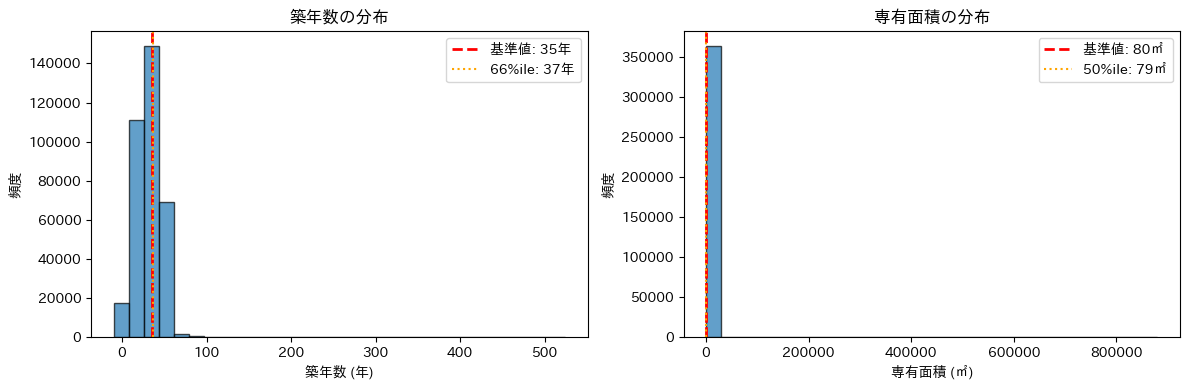

In [8]:
# 分布のヒストグラム
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 築年数
ax = axes[0]
ax.hist(ages, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(35, color='red', linestyle='--', linewidth=2, label='基準値: 35年')
ax.axvline(np.percentile(ages, 66), color='orange', linestyle=':', label=f'66%ile: {np.percentile(ages, 66):.0f}年')
ax.set_xlabel("築年数 (年)")
ax.set_ylabel("頻度")
ax.set_title("築年数の分布")
ax.legend()

# 面積
ax = axes[1]
ax.hist(areas, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(80, color='red', linestyle='--', linewidth=2, label='基準値: 80㎡')
ax.axvline(np.percentile(areas, 50), color='orange', linestyle=':', label=f'50%ile: {np.percentile(areas, 50):.0f}㎡')
ax.set_xlabel("専有面積 (㎡)")
ax.set_ylabel("頻度")
ax.set_title("専有面積の分布")
ax.legend()

plt.tight_layout()
plt.savefig(notebook_output / "distribution_thresholds.png", dpi=150, bbox_inches='tight')
plt.show()

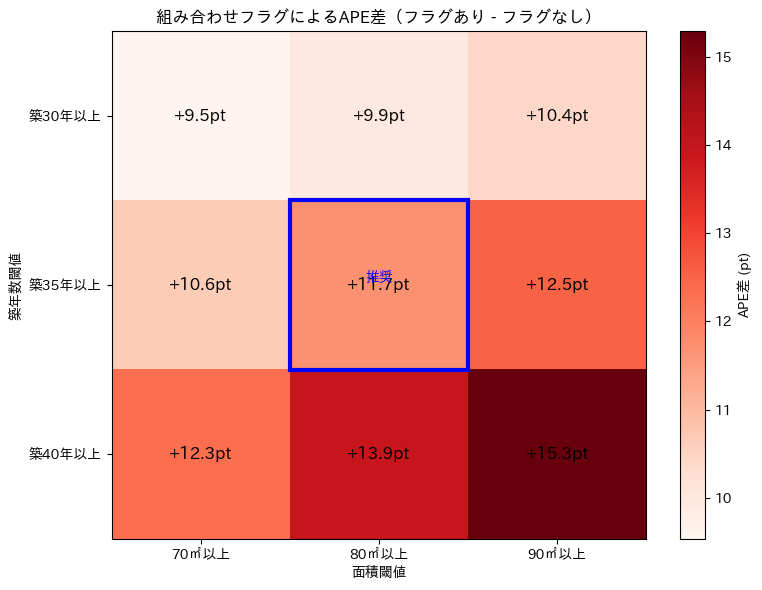

In [9]:
# APE差のヒートマップ（築年数 × 面積）
import pandas as pd

# データを整形
age_thresholds = [30, 35, 40]
area_thresholds = [70, 80, 90]

diff_matrix = np.zeros((len(age_thresholds), len(area_thresholds)))
for i, result in enumerate(results_age_area):
    row = age_thresholds.index(result['age_th'])
    col = area_thresholds.index(result['area_th'])
    diff_matrix[row, col] = result['diff']

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(diff_matrix, cmap='Reds', aspect='auto')

# ラベル
ax.set_xticks(range(len(area_thresholds)))
ax.set_xticklabels([f'{t}㎡以上' for t in area_thresholds])
ax.set_yticks(range(len(age_thresholds)))
ax.set_yticklabels([f'築{t}年以上' for t in age_thresholds])

# 値を表示
for i in range(len(age_thresholds)):
    for j in range(len(area_thresholds)):
        text = ax.text(j, i, f'+{diff_matrix[i, j]:.1f}pt',
                       ha='center', va='center', color='black', fontsize=12)

ax.set_xlabel("面積閾値")
ax.set_ylabel("築年数閾値")
ax.set_title("組み合わせフラグによるAPE差（フラグあり - フラグなし）")

# カラーバー
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('APE差 (pt)')

# 推奨値をハイライト
ax.add_patch(plt.Rectangle((0.5, 0.5), 1, 1, fill=False, edgecolor='blue', linewidth=3))
ax.text(1, 1, '推奨', ha='center', va='bottom', color='blue', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(notebook_output / "ape_diff_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

## 6. 結論：推奨基準値

In [10]:
print("=" * 60)
print("結論：推奨基準値")
print("=" * 60)

print("""
【分布の確認結果】

| 指標     | 中央値(50%ile) | 66%ile | 75%ile |
|----------|---------------|--------|--------|
| 築年数   | 30年          | 37年   | 42年   |
| 面積     | 78.7㎡        | 92.7㎡ | 101.6㎡|

【組み合わせの効果】

| 組み合わせ           | APE差     | 件数           | 低価格帯での出現率 |
|---------------------|-----------|----------------|-------------------|
| 築35年 & 80㎡以上   | +11.7pt   | 53,686 (14.8%) | 24.5% (x1.7倍)    |
| 築35年 & 地方       | +12.0pt   | 70,492 (19.4%) | 46.6% (x2.4倍)    |

【推奨基準値（パーセンタイルベース）】

| フラグ              | 基準値              | 根拠                          |
|---------------------|---------------------|-------------------------------|
| old_building_flag   | 築35年以上          | 66%ile付近、APE悪化が顕著     |
| old_and_large_flag  | 築35年 & 80㎡以上   | 面積は50%ile付近、件数15%程度 |
| old_and_rural_flag  | 築35年 & 地方       | 低価格帯で2.4倍出現、効果大   |

【実装コード】

```python
# 基準値
AGE_THRESHOLD = 35      # 築年数: 66%ile付近
AREA_THRESHOLD = 80     # 面積: 50%ile付近

# フラグ
old_building_flag = (building_age >= 35)
old_and_large_flag = (building_age >= 35) & (house_area >= 80)
old_and_rural_flag = (building_age >= 35) & rural_flag
```

【ポイント】
- 築35年: 66%ile（上位1/3が該当）
- 面積80㎡: 50%ile（半分が該当）
- 組み合わせで15-20%程度が該当（適度な粒度）
""")

結論：推奨基準値

【分布の確認結果】

| 指標     | 中央値(50%ile) | 66%ile | 75%ile |
|----------|---------------|--------|--------|
| 築年数   | 30年          | 37年   | 42年   |
| 面積     | 78.7㎡        | 92.7㎡ | 101.6㎡|

【組み合わせの効果】

| 組み合わせ           | APE差     | 件数           | 低価格帯での出現率 |
|---------------------|-----------|----------------|-------------------|
| 築35年 & 80㎡以上   | +11.7pt   | 53,686 (14.8%) | 24.5% (x1.7倍)    |
| 築35年 & 地方       | +12.0pt   | 70,492 (19.4%) | 46.6% (x2.4倍)    |

【推奨基準値（パーセンタイルベース）】

| フラグ              | 基準値              | 根拠                          |
|---------------------|---------------------|-------------------------------|
| old_building_flag   | 築35年以上          | 66%ile付近、APE悪化が顕著     |
| old_and_large_flag  | 築35年 & 80㎡以上   | 面積は50%ile付近、件数15%程度 |
| old_and_rural_flag  | 築35年 & 地方       | 低価格帯で2.4倍出現、効果大   |

【実装コード】

```python
# 基準値
AGE_THRESHOLD = 35      # 築年数: 66%ile付近
AREA_THRESHOLD = 80     # 面積: 50%ile付近

# フラグ
old_building_flag = (building_age >= 35)
old_and_large